In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
density_of_silicon_specific = 2.33 #g/cm3

In [3]:
# taken from my thesis
pdf_l = lambda l,t: 2 * t**2 / (l**3)

In [4]:
pdf_l(np.array(1),1)

np.float64(2.0)

In [5]:
pdf_l(l=1,t=1)

2.0

In [6]:
def uniform_to_length(uniform_array,thickness):
    return np.sqrt(thickness**2 / (1.0 - uniform_array))

def length_generator(n_particles,thickness):
    uniform_array = np.random.uniform(0,1,n_particles)
    array_of_lengths = uniform_to_length(uniform_array,thickness)
    return array_of_lengths



In [7]:
np.random.uniform(0,1,5)

array([0.90746013, 0.18610234, 0.60807549, 0.26389804, 0.31559218])

/tmp/ipykernel_7442/1991665128.py:2: RuntimeWarning: divide by zero encountered in divide
  pdf_l = lambda l,t: 2 * t**2 / (l**3)


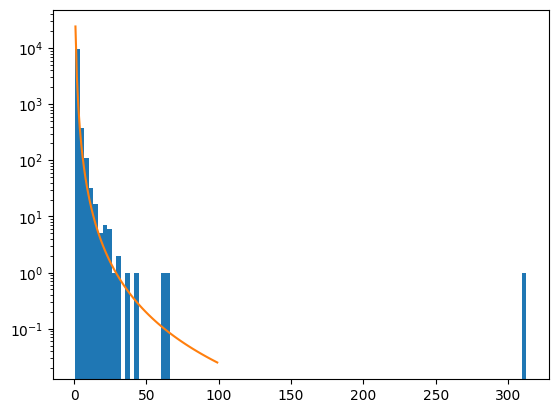

In [8]:
plt.hist(length_generator(10000,1),bins=100)
plt.plot(100 * pdf_l(np.linspace(0,20,100),1))
plt.yscale("log")

In [9]:
from star import ProtonSTARCalculator, ProtonMaterials

material = ProtonMaterials.SILICON
calculator = ProtonSTARCalculator(material)
total = calculator.calculate_total_stopping_powers( [10, 20, 50]) # Energy in MeV
total

array([34.5949806 , 20.20051304,  9.85638881])

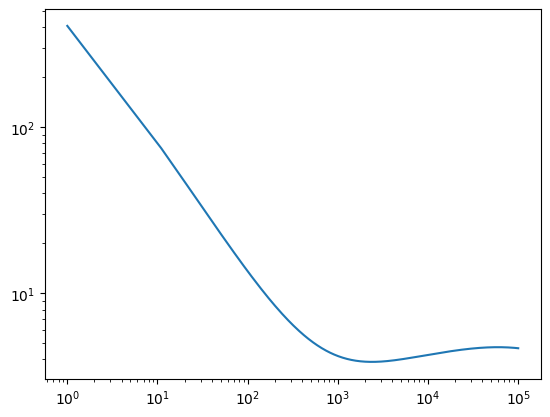

In [10]:
plt.plot(np.linspace(1,100_000,10_000),
         calculator.calculate_total_stopping_powers(np.linspace(1,100_000,10_000)) * density_of_silicon_specific)
plt.yscale("log")
plt.xscale("log")

In [11]:
import scipy.interpolate

stp_function = scipy.interpolate.interp1d(np.linspace(1,2_000,10_000),
                                          calculator.calculate_total_stopping_powers(np.linspace(1,2_000,10_000)) * density_of_silicon_specific,
                                          bounds_error=False,fill_value=np.nan)

reverse_stp_function = scipy.interpolate.interp1d(calculator.calculate_total_stopping_powers(np.linspace(1,2_000,10_000)) * density_of_silicon_specific,
                                                  np.linspace(1,2_000,10_000),bounds_error=False,fill_value=np.nan)

In [12]:
def power_law_generator(n_particles, A, lamb):

    uniform_array = np.random.uniform(0,1,n_particles)

    print((1/(1-lamb)))
    print((uniform_array * (1-lamb)) / A)

    return ((uniform_array * (1-lamb)) / A)**(-0.2)
    #return ((uniform_array * (1-lamb)) / A)**(1/(1-lamb))

In [13]:
def rndm_power_law(a, b, lamb, size=1):
    g=lamb + 1
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

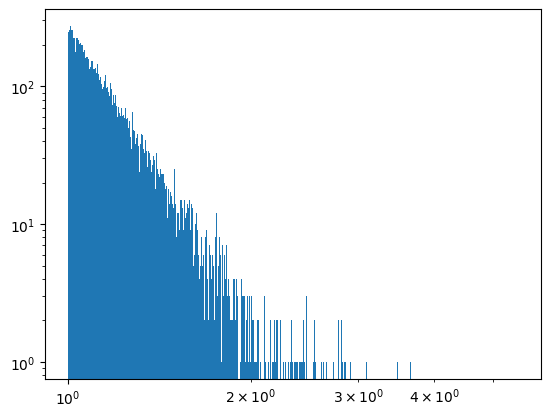

In [14]:
plt.hist(rndm_power_law(1, 1000, lamb=-7, size=10_000),bins=1000)
plt.xscale("log")
plt.yscale("log")

In [15]:
rndm_power_law(1, 1000, lamb=-7, size=10_000) * length_generator(10000,1)

array([29.46427323,  1.65310067,  1.5178083 , ...,  4.01841853,
        1.13203613,  1.3390905 ])

In [16]:
def calc_energy_from_rigidity_in_MeV(rigidity_in_GV,Z=1,A=1):
    T0 = A * 0.938
    energy_in_GeV = -T0 + np.sqrt(T0**2 + ((rigidity_in_GV * Z / A)**2))
    return energy_in_GeV * 1000.0

In [17]:
calc_energy_from_rigidity_in_MeV(1,1,1)

np.float64(433.0740315533659)

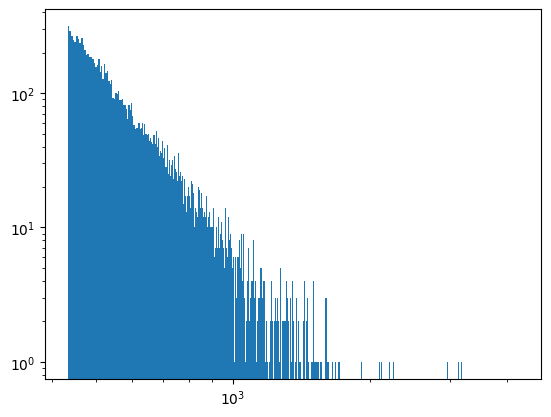

In [18]:
plt.hist(calc_energy_from_rigidity_in_MeV(rndm_power_law(1, 1000, lamb=-7, size=10_000)),bins=1000)
plt.xscale("log")
plt.yscale("log")

In [124]:
n_particles_specific = 1_000_000
det_thickness_cm_specific = 15 / 10_000
power_law_index = 4

def generate_MC_DF(n_particles, det_thickness_cm, density_of_silicon, use_uniform_STP=False):
    output_DF = pd.DataFrame()

    if use_uniform_STP is True:
        output_DF["stopping_power_vals"] = np.random.random(size=n_particles)
    else:
        output_DF["energy_vals"] = calc_energy_from_rigidity_in_MeV(rndm_power_law(1, 1000, lamb=-power_law_index, size=n_particles))
        output_DF["stopping_power_vals"] = calculator.calculate_total_stopping_powers(output_DF["energy_vals"]) * density_of_silicon

    output_DF["length_vals"] = length_generator(n_particles,det_thickness_cm)

    output_DF["tot_deposit_vals_MeV"] = output_DF["stopping_power_vals"] * output_DF["length_vals"]
    output_DF["tot_deposit_vals_keV"] = output_DF["tot_deposit_vals_MeV"] * 1000

    return output_DF

output_DF = generate_MC_DF(n_particles_specific, det_thickness_cm_specific, density_of_silicon_specific)

In [125]:
output_DF

,energy_vals,stopping_power_vals,length_vals,tot_deposit_vals_MeV,tot_deposit_vals_keV
0,911.472058,4.283111,0.001587,0.006797,6.797099
1,1910.447925,3.887429,0.016754,0.065129,65.129153
2,579.139297,4.907124,0.003899,0.019133,19.133187
3,1396.428644,3.981583,0.001872,0.007455,7.454692
4,556.810945,4.979826,0.002857,0.014228,14.228054
...,...,...,...,...,...
999995,473.133339,5.318402,0.002502,0.013308,13.308411
999996,1188.627775,4.068856,0.006528,0.026562,26.561546
999997,714.174329,4.572755,0.002209,0.010099,10.099400
999998,584.024216,4.892022,0.002942,0.014393,14.392713


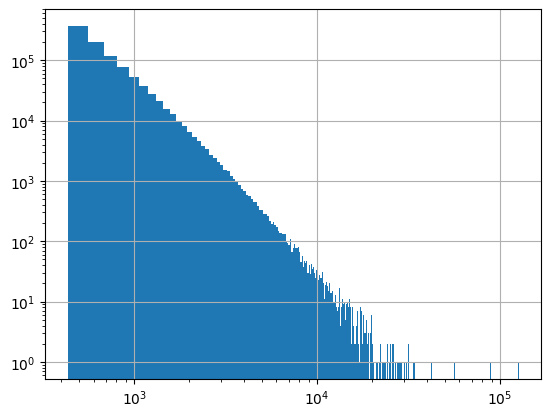

In [126]:
output_DF["energy_vals"].hist(bins=1000)
plt.xscale("log")
plt.yscale("log")

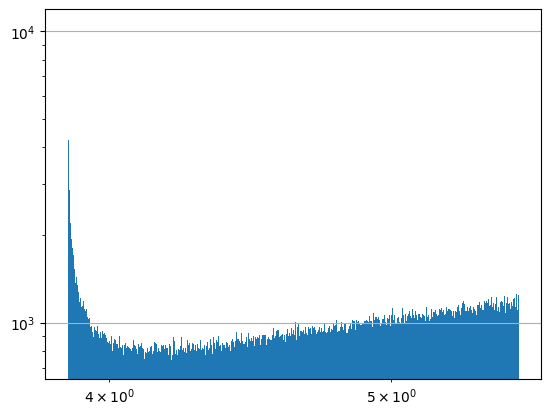

In [127]:
output_DF["stopping_power_vals"].hist(bins=1000)
plt.xscale("log")
plt.yscale("log")

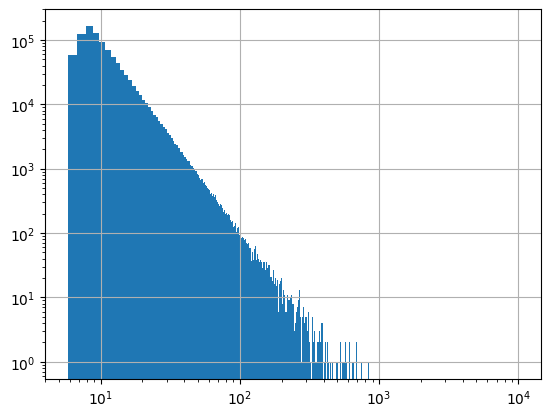

In [128]:
output_DF["tot_deposit_vals_keV"].hist(bins=10000)
plt.xscale("log")
plt.yscale("log")

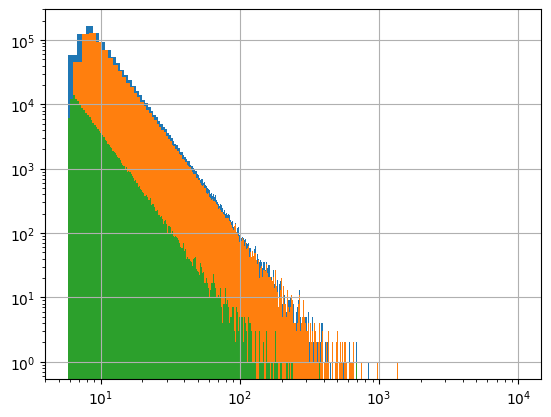

In [129]:
output_DF["tot_deposit_vals_keV"].hist(bins=10000)
output_DF[output_DF["energy_vals"] < 1000]["tot_deposit_vals_keV"].hist(bins=10000)
output_DF[output_DF["energy_vals"] >= 1000]["tot_deposit_vals_keV"].hist(bins=10000)
plt.xscale("log")
plt.yscale("log")

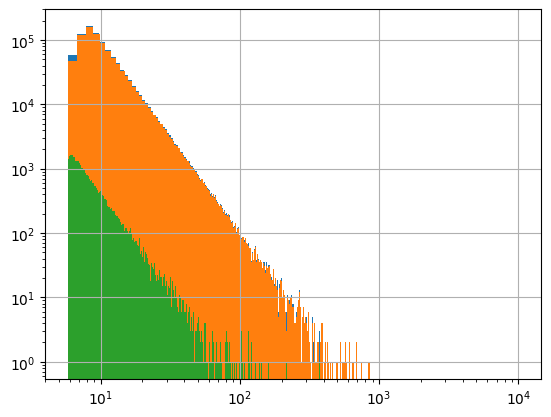

In [130]:
output_DF["tot_deposit_vals_keV"].hist(bins=10000)
output_DF[output_DF["energy_vals"] < 2000]["tot_deposit_vals_keV"].hist(bins=10000)
output_DF[output_DF["energy_vals"] >= 2000]["tot_deposit_vals_keV"].hist(bins=10000)
plt.xscale("log")
plt.yscale("log")

In [131]:
(pdf_Etot_vals, Etot_edges)  = np.histogram(output_DF["tot_deposit_vals_keV"],bins=10000)

Etot_mid_points = (Etot_edges[:1] + Etot_edges[1:]) / 2
dEtot = np.diff(Etot_edges)

In [132]:
Etot_mid_points

array([   6.30808633,    6.81064387,    7.31320142, ..., 5030.375844  ,
       5030.87840154, 5031.38095908])

In [133]:
dEtot

array([1.00511509, 1.00511509, 1.00511509, ..., 1.00511509, 1.00511509,
       1.00511509])

In [134]:
pdf_Etot_vals * (Etot_mid_points**3)

array([1.44758087e+07, 3.95807838e+07, 6.46125488e+07, ...,
       0.00000000e+00, 0.00000000e+00, 1.27368374e+11])

In [135]:
integrand = np.diff(pdf_Etot_vals * (Etot_mid_points**3)) / np.diff(Etot_mid_points)

In [136]:
Etot_super_mid = (Etot_mid_points[1:] + Etot_mid_points[:-1]) / 2

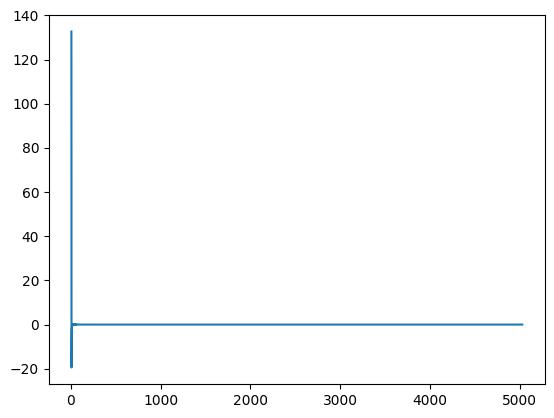

In [137]:
plt.plot(Etot_super_mid,
         integrand / (2 * (Etot_super_mid**3) / (det_thickness_cm_specific)))

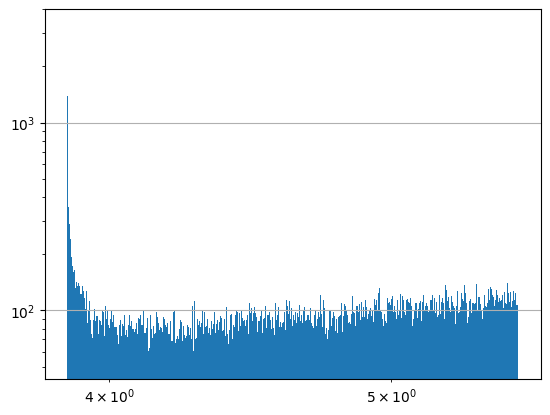

In [138]:
output_DF["stopping_power_vals"].hist(bins=10000)
plt.yscale("log")
plt.xscale("log")

## Testing uniform input dist

In [139]:
test_output_DF = generate_MC_DF(n_particles_specific, det_thickness_cm_specific, density_of_silicon_specific, use_uniform_STP=True)

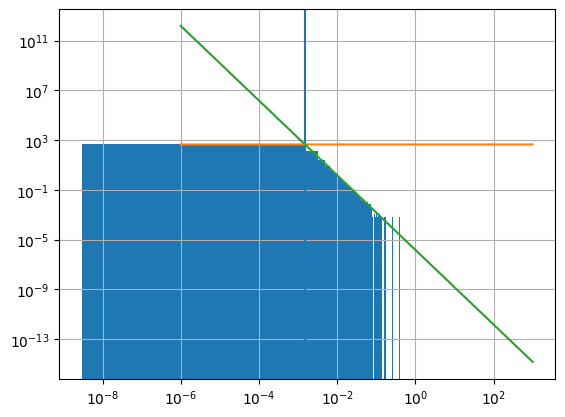

In [140]:
test_output_DF["tot_deposit_vals_MeV"].hist(bins=1_000,density=True)
plt.yscale("log")
plt.xscale("log")
plt.axvline(det_thickness_cm_specific)

test_X_vals = np.linspace(1e-6,1e3,100_000)
plt.plot(test_X_vals,(test_X_vals / test_X_vals) * (2/3) / det_thickness_cm_specific)
plt.plot(test_X_vals,2 * (det_thickness_cm_specific**2) / (3 * (test_X_vals ** 3)))

In [141]:
test_output_DF

,stopping_power_vals,length_vals,tot_deposit_vals_MeV,tot_deposit_vals_keV
0,0.732168,0.002088,0.001528,1.528404
1,0.198282,0.002379,0.000472,0.471777
2,0.002481,0.001909,0.000005,0.004735
3,0.398983,0.005289,0.002110,2.110040
4,0.916720,0.001933,0.001772,1.771644
...,...,...,...,...
999995,0.709789,0.005735,0.004071,4.070628
999996,0.931476,0.008100,0.007545,7.544688
999997,0.189796,0.001740,0.000330,0.330227
999998,0.868769,0.001671,0.001452,1.452011


In [142]:
test_backwards_vals, test_backwards_edges = np.histogram(test_output_DF["tot_deposit_vals_MeV"],bins=1_000,density=True)

test_backwards_edges_mids = (test_backwards_edges[:-1] + test_backwards_edges[1:]) / 2

In [143]:
test_backwards_vals

array([4.41403555e+02, 1.34197822e+02, 2.49617109e+01, 8.77734212e+00,
       4.04019637e+00, 2.23917488e+00, 1.30701283e+00, 8.48999790e-01,
       5.67861701e-01, 4.40015242e-01, 3.17133693e-01, 2.41418800e-01,
       1.84942937e-01, 1.50188559e-01, 1.05504360e-01, 1.07986815e-01,
       8.31622601e-02, 7.32324380e-02, 5.83377048e-02, 5.58552493e-02,
       4.09605162e-02, 3.53749912e-02, 3.59956051e-02, 2.97894663e-02,
       1.92390303e-02, 1.79978026e-02, 1.61359609e-02, 1.36535054e-02,
       1.30328915e-02, 1.55153470e-02, 1.17916637e-02, 1.36535054e-02,
       1.11710499e-02, 1.48947331e-02, 6.82675269e-03, 7.44736657e-03,
       8.68859434e-03, 1.11710499e-02, 1.05504360e-02, 6.20613881e-03,
       7.44736657e-03, 7.44736657e-03, 4.96491105e-03, 6.20613881e-03,
       6.82675269e-03, 3.10306941e-03, 3.72368329e-03, 3.72368329e-03,
       3.72368329e-03, 6.20613881e-04, 6.20613881e-04, 6.20613881e-03,
       0.00000000e+00, 2.48245552e-03, 6.20613881e-04, 1.24122776e-03,
      

In [144]:
test_backwards_edges_mids

array([8.05656851e-04, 2.41696467e-03, 4.02827249e-03, 5.63958031e-03,
       7.25088813e-03, 8.86219595e-03, 1.04735038e-02, 1.20848116e-02,
       1.36961194e-02, 1.53074272e-02, 1.69187351e-02, 1.85300429e-02,
       2.01413507e-02, 2.17526585e-02, 2.33639663e-02, 2.49752742e-02,
       2.65865820e-02, 2.81978898e-02, 2.98091976e-02, 3.14205054e-02,
       3.30318133e-02, 3.46431211e-02, 3.62544289e-02, 3.78657367e-02,
       3.94770445e-02, 4.10883523e-02, 4.26996602e-02, 4.43109680e-02,
       4.59222758e-02, 4.75335836e-02, 4.91448914e-02, 5.07561993e-02,
       5.23675071e-02, 5.39788149e-02, 5.55901227e-02, 5.72014305e-02,
       5.88127384e-02, 6.04240462e-02, 6.20353540e-02, 6.36466618e-02,
       6.52579696e-02, 6.68692775e-02, 6.84805853e-02, 7.00918931e-02,
       7.17032009e-02, 7.33145087e-02, 7.49258166e-02, 7.65371244e-02,
       7.81484322e-02, 7.97597400e-02, 8.13710478e-02, 8.29823557e-02,
       8.45936635e-02, 8.62049713e-02, 8.78162791e-02, 8.94275869e-02,
      

In [145]:
test_differential = np.diff(0.5 * (test_backwards_edges_mids**3) * det_thickness_cm_specific * test_backwards_vals) / np.diff(test_backwards_edges_mids)


test_backwards_edges_mids_super = (test_backwards_edges_mids[:-1] + test_backwards_edges_mids[1:])/2

test_differential

array([ 7.74499453e-07, -1.22464928e-07, -2.66741067e-08, -1.59007101e-08,
        8.52840145e-09, -2.64909404e-08, -1.49285560e-09, -1.83697362e-08,
        5.55351199e-08, -1.97375644e-08,  8.93952042e-11, -1.15883064e-08,
        1.61688535e-08, -9.32277074e-08,  1.56725507e-07, -5.56016356e-08,
        3.68121376e-08, -4.49959985e-08,  8.72112437e-08, -1.19326048e-07,
       -2.55096123e-09,  1.13801303e-07, -4.55818023e-08, -2.01874515e-07,
        3.01757688e-08,  3.61380700e-09, -3.18060186e-08,  3.45630087e-08,
        1.88133613e-07, -1.24146662e-07,  1.79519105e-07, -8.42589300e-08,
        3.43671164e-07, -5.44528427e-07,  1.02922250e-07,  1.73916432e-07,
        3.24403439e-07,  2.52740170e-08, -4.27601531e-07,  2.18569200e-07,
        7.31360600e-08, -2.94332202e-07,  2.52577062e-07,  1.76684302e-07,
       -6.02247119e-07,  1.59864966e-07,  4.80534326e-08,  5.01199350e-08,
       -6.80637498e-07,  9.06390927e-09,  1.49503737e-06, -1.65067476e-06,
        7.40220588e-07, -

(0.0, 0.003)

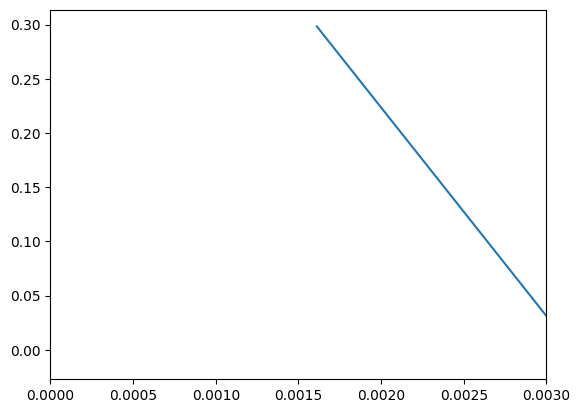

In [146]:
plt.plot(test_backwards_edges_mids_super, test_differential / (test_backwards_edges_mids_super**2))
plt.xlim([0,det_thickness_cm_specific*2])

## reversing MC distribution

In [147]:
def reverse_dist_to_stp(distribution_of_energy_deps,bins_to_use=10_000):

    backwards_vals, backwards_edges = np.histogram(distribution_of_energy_deps,
                                                   bins=bins_to_use,density=True)

    backwards_edges_mids = (backwards_edges[:-1] + backwards_edges[1:]) / 2

    differential = np.diff(0.5 * (backwards_edges_mids**3) * det_thickness_cm_specific * backwards_vals) / np.diff(backwards_edges_mids)

    backwards_edges_mids_super = (backwards_edges_mids[:-1] + backwards_edges_mids[1:])/2

    output_vals = differential / (backwards_edges_mids_super**2)

    return backwards_edges_mids_super, output_vals

In [148]:
output_DF.head()

,energy_vals,stopping_power_vals,length_vals,tot_deposit_vals_MeV,tot_deposit_vals_keV
0,911.472058,4.283111,0.001587,0.006797,6.797099
1,1910.447925,3.887429,0.016754,0.065129,65.129153
2,579.139297,4.907124,0.003899,0.019133,19.133187
3,1396.428644,3.981583,0.001872,0.007455,7.454692
4,556.810945,4.979826,0.002857,0.014228,14.228054


Text(0.5, 0, 'Energy (MeV)')

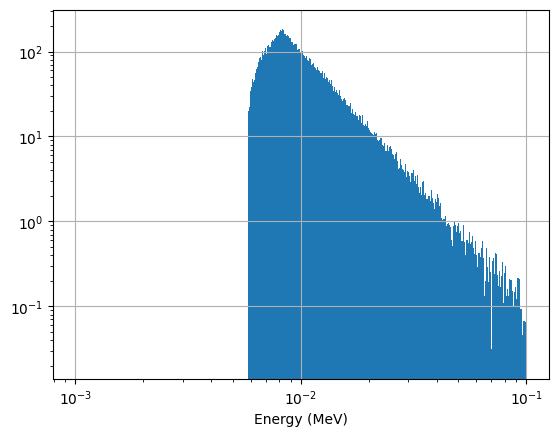

In [149]:
output_DF.tot_deposit_vals_MeV.hist(#bins=10_000,
                                    bins=np.geomspace(1e-3,1e-1,10_000),
                                    density=True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (MeV)")

In [150]:
#deposit_vals_to_use = output_DF.tot_deposit_vals_MeV
deposit_vals_to_use = output_DF.tot_deposit_vals_MeV[output_DF.tot_deposit_vals_MeV <= 15e-3]

specific_bkg_edges, specific_output_vals = reverse_dist_to_stp(deposit_vals_to_use,bins_to_use=np.geomspace(1e-3,1e-1,300))

(0.0, 10.0)

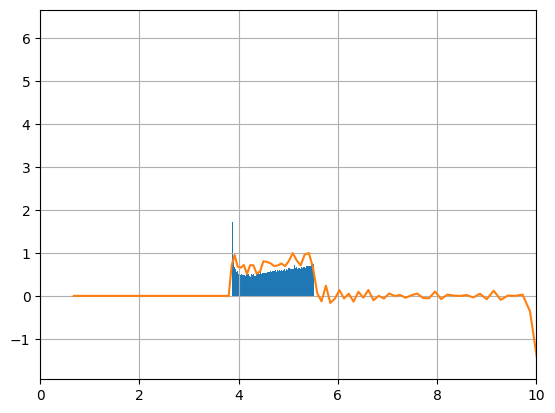

In [151]:
output_DF.stopping_power_vals.hist(density=True,bins=1000)
plt.plot(specific_bkg_edges/det_thickness_cm_specific, specific_output_vals)
plt.xlim([0,10])


In [152]:
reverse_stp_function

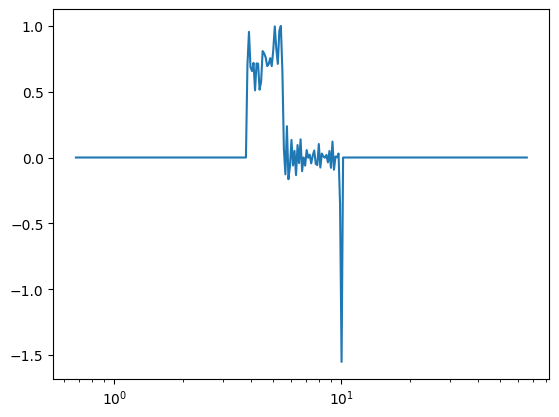

In [153]:
stp_power_vals = specific_bkg_edges/det_thickness_cm_specific

plt.plot(stp_power_vals, specific_output_vals)
plt.xscale("log")
#plt.yscale("log")

In [154]:
prim_energy_values = reverse_stp_function(stp_power_vals)
prim_energy_values_mid = (prim_energy_values[:-1] + prim_energy_values[1:]) / 2
prim_energy_values_mid

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

In [155]:
delta_stp_vals = np.diff(stp_power_vals)
delta_prim_energy_vals = np.diff(prim_energy_values)

In [156]:
specific_output_vals_mid = (specific_output_vals[:-1] + specific_output_vals[1:]) / 2

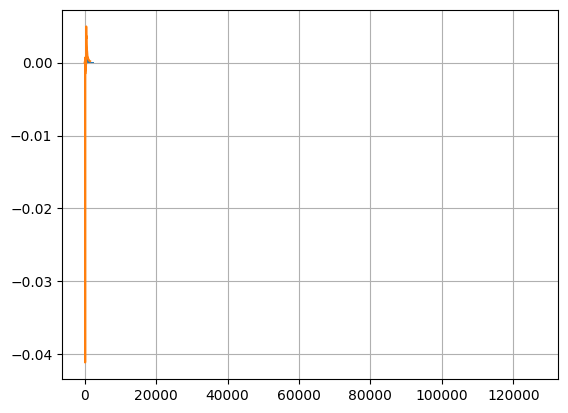

In [157]:
output_DF.energy_vals.hist(density=True,bins=1000)

plt.plot(prim_energy_values_mid, specific_output_vals_mid * np.abs(delta_stp_vals / delta_prim_energy_vals))

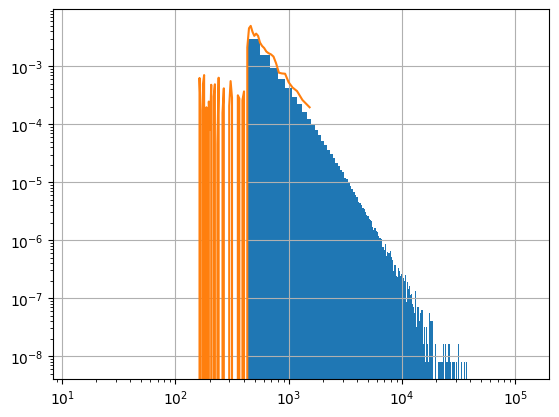

In [158]:
output_DF.energy_vals.hist(density=True,bins=1000)

plt.plot(prim_energy_values_mid, 
         specific_output_vals_mid * np.abs(delta_stp_vals / delta_prim_energy_vals))

#plt.xlim([400,1000])
#plt.ylim([-0.02,0.05])
plt.yscale("log")
plt.xscale("log")